# Italian Exercise Generator - Model Evaluation

**Purpose**: Evaluate the fine-tuned model on the test dataset

**GPU**: L4 (22GB) - enough for inference

**Dataset**: 403 test examples (1,964 exercises)

**Metrics**:
- JSON validity (can we parse the output?)
- Exercise completeness (all required fields present?)
- Grammar accuracy (manual spot-check)
- Format consistency

**Time**: ~30-45 minutes for full test set

## 1. Setup

In [1]:
# Check GPU
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv

name, memory.total [MiB], memory.free [MiB]
NVIDIA L4, 23034 MiB, 22692 MiB


In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Colab\ Notebooks/italian_teacher

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/italian_teacher


In [3]:
# Install dependencies
!pip install -q transformers>=4.36.0 datasets accelerate peft bitsandbytes sentencepiece protobuf pandas matplotlib seaborn

## 2. Load Model & Test Data

In [4]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import PeftModel
import torch
import json
from pathlib import Path
from tqdm.auto import tqdm
import pandas as pd

print("Loading model...")

# Quantization config for L4
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=False,  # Save memory on L4
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

# Load base model
base_model = AutoModelForCausalLM.from_pretrained(
    "swap-uniba/LLaMAntino-3-ANITA-8B-Inst-DPO-ITA",
    quantization_config=bnb_config,
    device_map="auto",
    torch_dtype=torch.float16,
)

# Load LoRA adapter
model = PeftModel.from_pretrained(
    base_model,
    "./models/italian_exercise_generator_lora"
)

tokenizer = AutoTokenizer.from_pretrained(
    "./models/italian_exercise_generator_lora"
)

print(f"✅ Model loaded on {torch.cuda.get_device_name(0)}")
print(f"💾 VRAM used: {torch.cuda.memory_allocated() / 1e9:.1f} GB")

Loading model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/182 [00:00<?, ?B/s]

✅ Model loaded on NVIDIA L4
💾 VRAM used: 6.2 GB


In [5]:
# Load test dataset
test_file = Path("data/datasets/final/test.jsonl")

test_data = []
with open(test_file, 'r') as f:
    for line in f:
        test_data.append(json.loads(line))

print(f"📊 Loaded {len(test_data)} test examples")

# Show distribution
from collections import Counter
levels = Counter(item['metadata']['cefr_level'] for item in test_data)
print(f"\n📈 Test set distribution:")
for level in ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']:
    if level in levels:
        print(f"   {level}: {levels[level]:3} examples ({levels[level]/len(test_data)*100:5.1f}%)")

📊 Loaded 403 test examples

📈 Test set distribution:
   A1:  99 examples ( 24.6%)
   A2: 145 examples ( 36.0%)
   B1:  62 examples ( 15.4%)
   B2:  47 examples ( 11.7%)
   C1:  41 examples ( 10.2%)
   C2:   9 examples (  2.2%)


## 3. Define Evaluation Functions

In [6]:
def generate_exercises(model, tokenizer, user_prompt, max_new_tokens=512):
    """Generate exercises from user prompt."""
    messages = [
        {
            "role": "system",
            "content": "You are an expert Italian language teacher. Generate high-quality exercises based on the assignment specification. Output exercises in JSON format."
        },
        {
            "role": "user",
            "content": user_prompt
        }
    ]

    inputs = tokenizer.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=True,
        return_tensors="pt"
    ).to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            inputs,
            max_new_tokens=max_new_tokens,
            temperature=0.7,
            do_sample=True,
            top_p=0.9,
            pad_token_id=tokenizer.eos_token_id
        )

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract assistant response
    if "assistant" in response:
        response = response.split("assistant")[-1].strip()

    return response


def validate_json_output(output_text):
    """Check if output is valid JSON."""
    try:
        exercises = json.loads(output_text)
        if isinstance(exercises, list):
            return True, exercises, None
        else:
            return False, None, "Output is not a list"
    except json.JSONDecodeError as e:
        return False, None, str(e)


def check_exercise_completeness(exercise):
    """Check if exercise has required fields."""
    required = ['type', 'question', 'answer']
    optional = ['explanation', 'hint', 'options']

    missing = [field for field in required if field not in exercise]

    if missing:
        return False, f"Missing: {missing}"

    # Check type-specific requirements
    if exercise['type'] == 'multiple_choice' and 'options' not in exercise:
        return False, "Multiple choice missing options"

    return True, "Complete"


def evaluate_example(model, tokenizer, example):
    """Evaluate a single test example."""
    user_prompt = example['messages'][1]['content']
    expected = example['messages'][2]['content']
    metadata = example['metadata']

    # Generate
    generated = generate_exercises(model, tokenizer, user_prompt)

    # Validate JSON
    is_valid, exercises, error = validate_json_output(generated)

    result = {
        'cefr_level': metadata['cefr_level'],
        'exercise_type': metadata.get('exercise_type', 'unknown'),
        'grammar_focus': metadata.get('grammar_focus', 'unknown'),
        'num_requested': metadata.get('num_exercises', 0),
        'json_valid': is_valid,
        'json_error': error,
        'num_generated': len(exercises) if exercises else 0,
        'generated_text': generated,
        'expected_text': expected
    }

    # Check completeness of each exercise
    if exercises:
        complete_count = 0
        for ex in exercises:
            is_complete, msg = check_exercise_completeness(ex)
            if is_complete:
                complete_count += 1

        result['complete_exercises'] = complete_count
        result['completeness_rate'] = complete_count / len(exercises) if exercises else 0
    else:
        result['complete_exercises'] = 0
        result['completeness_rate'] = 0

    return result

print("✅ Evaluation functions defined")

✅ Evaluation functions defined


## 4. Run Evaluation on Test Set

In [7]:
# Evaluate a subset first (for testing)
SAMPLE_SIZE = 50  # Start with 50 examples, then run full set

print(f"🔍 Evaluating {SAMPLE_SIZE} examples...\n")

results = []
for i, example in enumerate(tqdm(test_data[:SAMPLE_SIZE], desc="Evaluating")):
    result = evaluate_example(model, tokenizer, example)
    results.append(result)

    # Print progress every 10 examples
    if (i + 1) % 10 == 0:
        valid_count = sum(1 for r in results if r['json_valid'])
        print(f"   Progress: {i+1}/{SAMPLE_SIZE} - Valid JSON: {valid_count}/{i+1} ({valid_count/(i+1)*100:.1f}%)")

print("\n✅ Evaluation complete!")

🔍 Evaluating 50 examples...



Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


   Progress: 10/50 - Valid JSON: 8/10 (80.0%)
   Progress: 20/50 - Valid JSON: 15/20 (75.0%)
   Progress: 30/50 - Valid JSON: 22/30 (73.3%)
   Progress: 40/50 - Valid JSON: 29/40 (72.5%)
   Progress: 50/50 - Valid JSON: 38/50 (76.0%)

✅ Evaluation complete!


## 5. Analyze Results

In [8]:
# Create DataFrame for analysis
df = pd.DataFrame(results)

print("📊 EVALUATION SUMMARY")
print("=" * 80)

# Overall metrics
print(f"\n📈 Overall Metrics (n={len(df)}):")
print(f"   JSON Validity:        {df['json_valid'].sum()}/{len(df)} ({df['json_valid'].mean()*100:.1f}%)")
print(f"   Avg Exercises/Sample: {df['num_generated'].mean():.1f}")
print(f"   Completeness Rate:    {df['completeness_rate'].mean()*100:.1f}%")

# By CEFR level
print(f"\n📊 Performance by CEFR Level:")
by_level = df.groupby('cefr_level').agg({
    'json_valid': ['count', 'sum', 'mean'],
    'completeness_rate': 'mean',
    'num_generated': 'mean'
}).round(3)

for level in ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']:
    if level in by_level.index:
        row = by_level.loc[level]
        count = int(row[('json_valid', 'count')])
        valid = int(row[('json_valid', 'sum')])
        valid_pct = row[('json_valid', 'mean')] * 100
        complete_pct = row[('completeness_rate', 'mean')] * 100
        avg_ex = row[('num_generated', 'mean')]
        print(f"   {level}: {valid}/{count} valid ({valid_pct:5.1f}%) | Completeness: {complete_pct:5.1f}% | Avg exercises: {avg_ex:.1f}")

# Common errors
print(f"\n❌ JSON Errors (if any):")
error_counts = df[~df['json_valid']]['json_error'].value_counts()
if len(error_counts) > 0:
    for error, count in error_counts.head(5).items():
        print(f"   {error[:60]}: {count} occurrences")
else:
    print("   ✅ No JSON errors!")

print("\n" + "=" * 80)

📊 EVALUATION SUMMARY

📈 Overall Metrics (n=50):
   JSON Validity:        38/50 (76.0%)
   Avg Exercises/Sample: 3.0
   Completeness Rate:    76.0%

📊 Performance by CEFR Level:
   A2: 9/9 valid (100.0%) | Completeness: 100.0% | Avg exercises: 3.9
   C1: 29/41 valid ( 70.7%) | Completeness:  70.7% | Avg exercises: 2.8

❌ JSON Errors (if any):
   Extra data: line 1 column 1143 (char 1142): 1 occurrences
   Expecting ',' delimiter: line 1 column 1676 (char 1675): 1 occurrences
   Unterminated string starting at: line 1 column 1781 (char 17: 1 occurrences
   Unterminated string starting at: line 1 column 1761 (char 17: 1 occurrences
   Unterminated string starting at: line 1 column 1650 (char 16: 1 occurrences



## 6. Sample Outputs Review

In [9]:
# Show some example outputs
print("📝 Sample Outputs:\n")

# Show one good example from each level
for level in ['A1', 'B1', 'C1']:
    level_results = [r for r in results if r['cefr_level'] == level and r['json_valid']]
    if level_results:
        sample = level_results[0]
        print(f"\n{'='*80}")
        print(f"Level {level} - {sample['exercise_type']} ({sample['grammar_focus']})")
        print(f"{'='*80}")

        try:
            exercises = json.loads(sample['generated_text'])
            if exercises:
                ex = exercises[0]  # Show first exercise
                print(f"Type: {ex.get('type', 'N/A')}")
                print(f"Question: {ex.get('question', 'N/A')[:150]}")
                print(f"Answer: {ex.get('answer', 'N/A')[:100]}")
                if 'explanation' in ex:
                    print(f"Explanation: {ex['explanation'][:150]}")
        except:
            print("(Could not parse)")

📝 Sample Outputs:


Level C1 - unknown (conjunctions)
Type: fill_in_blank
Question: ___ la tecnologia avanzi rapidamente, molte persone preferiscono metodi tradizionali.
Answer: Sebbene
Explanation: 'Sebbene' + subjunctive = although. Can also: 'Nonostante', 'Benché'.


## 7. Visualize Results

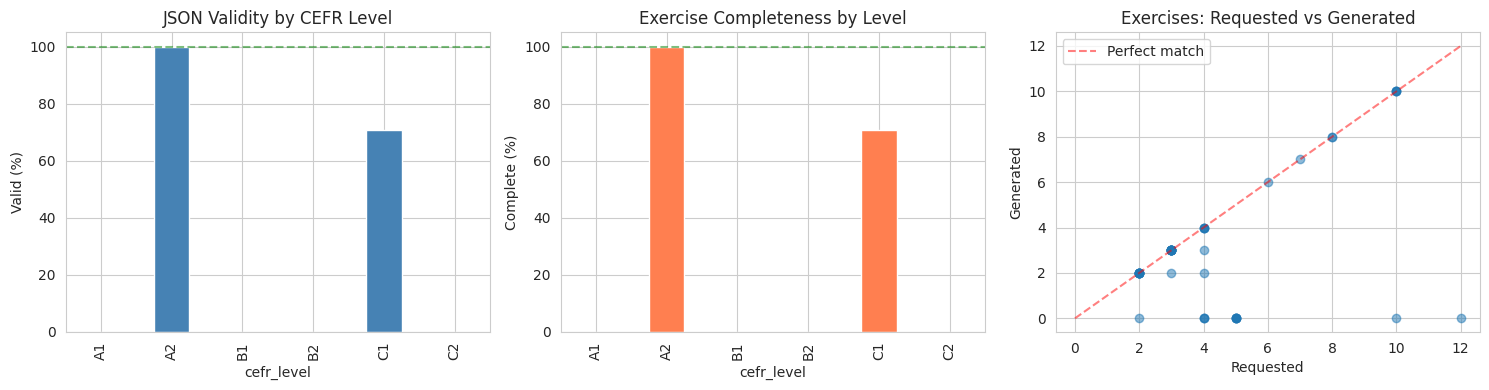


✅ Visualizations saved to evaluation_results.png


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. JSON Validity by Level
level_validity = df.groupby('cefr_level')['json_valid'].mean() * 100
level_validity = level_validity.reindex(['A1', 'A2', 'B1', 'B2', 'C1', 'C2'], fill_value=0)
level_validity.plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('JSON Validity by CEFR Level')
axes[0].set_ylabel('Valid (%)')
axes[0].set_ylim(0, 105)
axes[0].axhline(y=100, color='green', linestyle='--', alpha=0.5)

# 2. Completeness Rate by Level
level_complete = df.groupby('cefr_level')['completeness_rate'].mean() * 100
level_complete = level_complete.reindex(['A1', 'A2', 'B1', 'B2', 'C1', 'C2'], fill_value=0)
level_complete.plot(kind='bar', ax=axes[1], color='coral')
axes[1].set_title('Exercise Completeness by Level')
axes[1].set_ylabel('Complete (%)')
axes[1].set_ylim(0, 105)
axes[1].axhline(y=100, color='green', linestyle='--', alpha=0.5)

# 3. Number of Exercises Generated vs Requested
df_plot = df[df['num_requested'] > 0].copy()
if len(df_plot) > 0:
    axes[2].scatter(df_plot['num_requested'], df_plot['num_generated'], alpha=0.5)
    axes[2].plot([0, df_plot['num_requested'].max()], [0, df_plot['num_requested'].max()], 'r--', alpha=0.5, label='Perfect match')
    axes[2].set_xlabel('Requested')
    axes[2].set_ylabel('Generated')
    axes[2].set_title('Exercises: Requested vs Generated')
    axes[2].legend()

plt.tight_layout()
plt.savefig('evaluation_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Visualizations saved to evaluation_results.png")

## 8. Save Detailed Results

In [11]:
# Save results to CSV
output_csv = "evaluation_results.csv"
df.to_csv(output_csv, index=False)
print(f"✅ Detailed results saved to: {output_csv}")

# Save summary report
summary = {
    "total_examples": len(df),
    "json_validity_rate": float(df['json_valid'].mean()),
    "avg_completeness_rate": float(df['completeness_rate'].mean()),
    "avg_exercises_per_sample": float(df['num_generated'].mean()),
    "by_level": {}
}

for level in ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']:
    level_df = df[df['cefr_level'] == level]
    if len(level_df) > 0:
        summary['by_level'][level] = {
            "count": len(level_df),
            "json_validity": float(level_df['json_valid'].mean()),
            "completeness": float(level_df['completeness_rate'].mean()),
            "avg_exercises": float(level_df['num_generated'].mean())
        }

with open('evaluation_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print(f"✅ Summary saved to: evaluation_summary.json")
print("\n📊 Quick Summary:")
print(json.dumps(summary, indent=2))

✅ Detailed results saved to: evaluation_results.csv
✅ Summary saved to: evaluation_summary.json

📊 Quick Summary:
{
  "total_examples": 50,
  "json_validity_rate": 0.76,
  "avg_completeness_rate": 0.76,
  "avg_exercises_per_sample": 3.02,
  "by_level": {
    "A2": {
      "count": 9,
      "json_validity": 1.0,
      "completeness": 1.0,
      "avg_exercises": 3.888888888888889
    },
    "C1": {
      "count": 41,
      "json_validity": 0.7073170731707317,
      "completeness": 0.7073170731707317,
      "avg_exercises": 2.8292682926829267
    }
  }
}


## 9. Optional: Run Full Test Set

In [12]:
# Uncomment to run on FULL test set (403 examples, ~30-45 minutes)

# print(f"🔍 Evaluating FULL test set ({len(test_data)} examples)...\n")
# print("⏰ Estimated time: 30-45 minutes")
# print("\n")

# results_full = []
# for i, example in enumerate(tqdm(test_data, desc="Evaluating full set")):
#     result = evaluate_example(model, tokenizer, example)
#     results_full.append(result)

#     # Save checkpoint every 50 examples
#     if (i + 1) % 50 == 0:
#         df_checkpoint = pd.DataFrame(results_full)
#         df_checkpoint.to_csv(f"evaluation_checkpoint_{i+1}.csv", index=False)
#         print(f"   Checkpoint saved: {i+1}/{len(test_data)}")

# # Save final results
# df_full = pd.DataFrame(results_full)
# df_full.to_csv("evaluation_results_full.csv", index=False)
# print("\n✅ Full evaluation complete!")
# print(f"   Results saved to: evaluation_results_full.csv")

## 10. Conclusion

In [13]:
print("\n" + "=" * 80)
print("📊 EVALUATION COMPLETE")
print("=" * 80)
print(f"\n✅ Evaluated {len(df)} examples")
print(f"\n📁 Output files:")
print(f"   - evaluation_results.csv (detailed results)")
print(f"   - evaluation_summary.json (summary metrics)")
print(f"   - evaluation_results.png (visualizations)")
print(f"\n💡 Next steps:")
print(f"   1. Review samples with JSON errors (if any)")
print(f"   2. Check completeness of exercises")
print(f"   3. Manual quality review of generated exercises")
print(f"   4. Compare with baseline/other models")
print("\n" + "=" * 80)


📊 EVALUATION COMPLETE

✅ Evaluated 50 examples

📁 Output files:
   - evaluation_results.csv (detailed results)
   - evaluation_summary.json (summary metrics)
   - evaluation_results.png (visualizations)

💡 Next steps:
   1. Review samples with JSON errors (if any)
   2. Check completeness of exercises
   3. Manual quality review of generated exercises
   4. Compare with baseline/other models

